In [1]:
#installing the libraries
!pip install dill
!pip install path

#Import Standard Data Analysis Libraries
import datetime
import numpy as np
import pandas as pd
import re
import scipy.io

#Import dill library to save variables generated
import dill
import pickle
import path
import os

#import a plotting component
import matplotlib.pyplot as plt

from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.0 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:

#n_train: number of training data samples
#n_test: number of test data samples
#tensor_dimensions: The dimensionality of the tensor.
#tensor_mode_ranks: Ranks along each mode of tensor
#separation_rank: S for LSR Decomposition

### CODE FOR DATA GENERATION

import numpy as np

#n_train: number of training data samples
#n_test: number of test data samples
#tensor_dimensions: The dimensionality of the tensor.
#tensor_mode_ranks: Ranks along each mode of tensor
#separation_rank: S for LSR Decomposition
#if intercept =! 0 then the synthetic data is not centered

def generate_data(n_train, n_test, tensor_dimensions: np.ndarray,\
                  tensor_mode_ranks: np.ndarray, separation_rank, intercept = 0):

    #Calculate number of tensor dimensions
    D = len(tensor_dimensions)

    #generating the training and testing together
    output_tensor_shape = tuple(np.append(n_train + n_test , tensor_dimensions))

    #Generate Core Tensor
    size = np.prod(tensor_mode_ranks)
    G1 = np.random.normal(0, 1, size)
    G1 = G1.reshape(tensor_mode_ranks)
    G1 = G1 / np.linalg.norm(G1, ord = 'fro')

    #generating the factor matrices
    all_factor_matrices=[]
    for s in range (separation_rank):
        mode_s_factormatrices = []
        for k in range(D):
            dummy_mat = np.random.normal(0, 1, size = (tensor_dimensions[k], tensor_mode_ranks[k]) )
            mode_s_factormatrices.append(dummy_mat)
        all_factor_matrices.append(mode_s_factormatrices)

    print('Initiallizng Core Tensor and Factor Matrices: Done')

    #Using the Factor Matrices and Core Tensor, Generate B
    B_tensor_prior_N = np.zeros(tensor_dimensions)
    for s in range(separation_rank):
        B_tensor_prior_N += all_factor_matrices[s][0] @ G1 @ all_factor_matrices[s][1].T

    # Normalizing

    #norms = np.linalg.norm(B_tensor_prior_N, ord = 'fro')
    B_tensor = B_tensor_prior_N #/norms

    print('Generating the Parameter Tensor: Done')

    #Generate X
    X = np.random.normal(0,0.5,size=(output_tensor_shape)) # can this affect we are drawing all the points for the covariates at once

    #generating the dependent variable
    B_tensor_flatten = B_tensor.flatten(order ='F')
    X_transpose = np.transpose(X, (0,2,1))
    X_transpose_vectorized = np.reshape(X_transpose, newshape = (X_transpose.shape[0],-1))
    y_no_noise = np.dot(X_transpose_vectorized, B_tensor_flatten) + intercept
    y = y_no_noise + np.random.normal(0, 0.01, size = y_no_noise.shape)
    print('Generating Data: Done')
    if intercept != 0:
       print('Data generated with an intercept')

    #Split into X_train, X_test, Y_train,Y_test
    X_train = X[:n_train]
    X_test  = X[n_train:n_train+n_test]
    y_train = y[:n_train]
    y_test  = y[n_train:n_train+n_test]
    print('Splitting into Train/Test: Done')

    return X_train, y_train, X_test, y_test, B_tensor,G1,all_factor_matrices,y_no_noise

In [3]:
# Function to mean and the energy


def mean_energy(A):
  mean    = np.mean(A)
  energy  = np.sum((A-mean)**2)/(np.size(A)-1)  # cause we are calculating the energy of a sample from the population we use n-1
  return mean, energy


In [4]:
n_train = 5000
n_test = 1000

tensor_dimensions = np.array([32, 32])
tensor_mode_ranks = np.array([4, 4])
separation_rank = 2
intercept = 0


X_train_all, Y_train_all, X_test, Y_test, B_tensored,G1,all_factormatrices,Y_train_nonoise = generate_data(n_train, n_test, tensor_dimensions, tensor_mode_ranks, separation_rank, intercept= intercept)



Initiallizng Core Tensor and Factor Matrices: Done
Generating the Parameter Tensor: Done
Generating Data: Done
Splitting into Train/Test: Done


In [5]:
#saving the data needed

if os.path.exists('/content/gdrive/MyDrive/Colab Notebooks/Tensor_Based_LRR/Proper Experiments/The Pipeline/Experimental Data/32-32-4-4/Seperation Rank 2') == False:
  os.mkdir('/content/gdrive/MyDrive/Colab Notebooks/Tensor_Based_LRR/Proper Experiments/The Pipeline/Experimental Data/32-32-4-4/Seperation Rank 2')

formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
pkl_file = f"/content/gdrive/MyDrive/Colab Notebooks/Tensor_Based_LRR/Proper Experiments/The Pipeline/Experimental Data/32-32-4-4/Seperation Rank 2/Bounded_Var_Time:{formatted_time}, intercept:{intercept},n_train:{n_train}, n_test:{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}.pkl"
with open(pkl_file, "wb") as file:
    dill.dump((X_train_all, Y_train_all, X_test, Y_test, B_tensored,G1,all_factormatrices,Y_train_nonoise), file)

### When reusing the data do it from here.

In [ ]:
import pickle

file= open("/content/gdrive/MyDrive/Colab Notebooks/Tensor_Based_LRR/Proper Experiments/The Pipeline/Experimental Data/64-64-8-8/Bounded_Var_Time:2024-03-25 15:58:57, intercept:0,n_train:5000, n_test:1000, tensor_dimensions:[64 64], tensor_mode_ranks:[8 8], separation_rank:1.pkl", 'rb')
data = pickle.load(file)
file.close()

X_train = data[0]
print(data[0].shape)

Y_train = data[1]
print(data[1].shape)

X_test = data[2]
print(data[2].shape)

Y_test = data[3]
print(data[3].shape)

B_tensored = data[4]
print(data[4].shape)

G1 = data[5]
print(data[5].shape)

all_factormatrices = data[6]
#print(data[6].shape)

Y_train_nonoise = data[7]
print(data[7].shape)


(5000, 16, 16)
(5000,)
(1000, 16, 16)
(1000,)
(16, 16)
(4, 4)
(6000,)


Factor Matrix 0 0
mean -0.11583329270289369 energy 0.8122939598566642



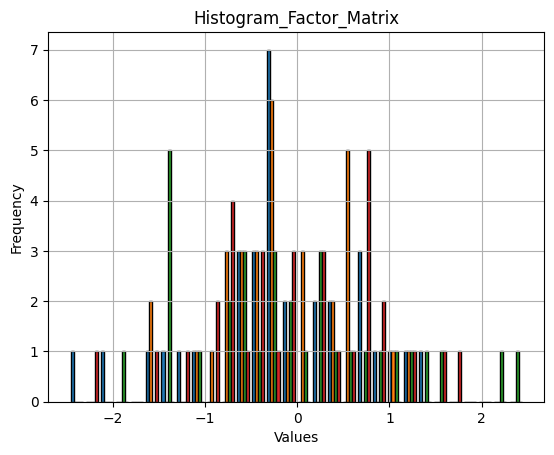

Factor Matrix 0 1
mean 0.09395068474769211 energy 0.9634686159193406



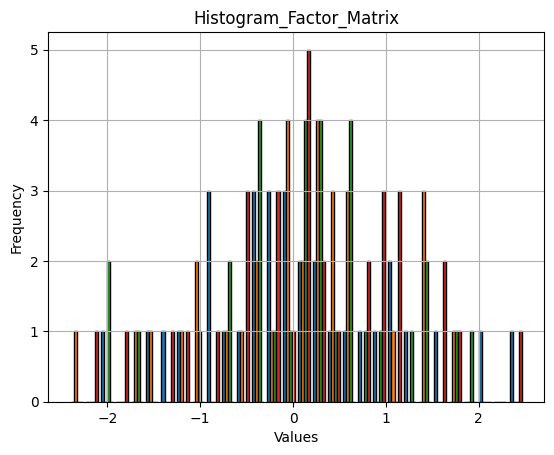

Factor Matrix 1 0
mean 0.01970160912571168 energy 0.9728176811718714



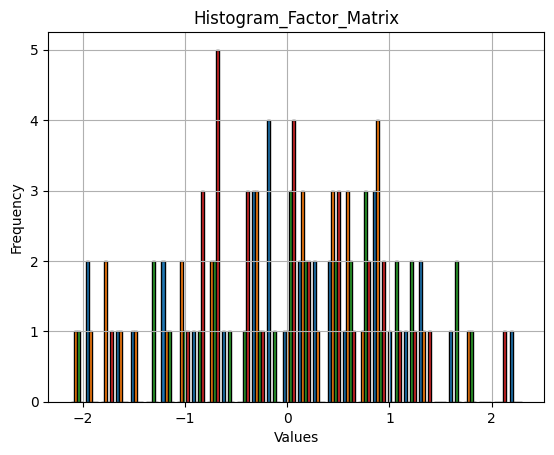

Factor Matrix 1 1
mean 0.0961608519785669 energy 1.195395932292884



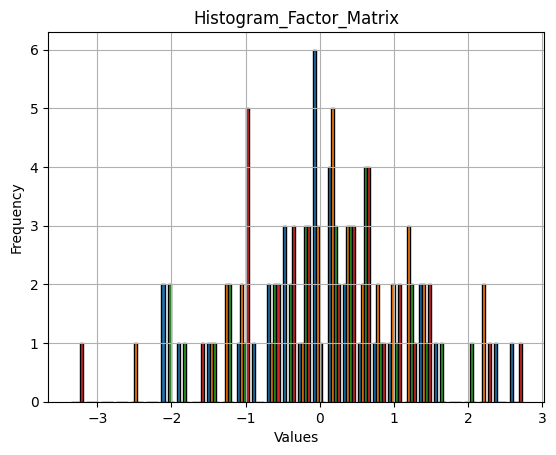

Core Tensor
mean 0.017101620951490953 energy: 0.06635470353155364



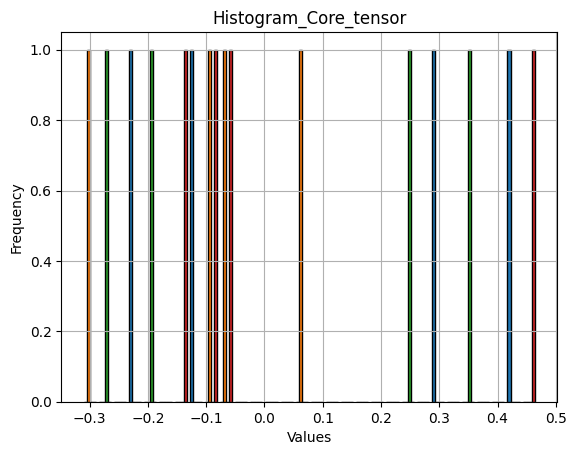

In [6]:
#factor to numpy

#all_fac_nd = []
#for s, term_s_factors in enumerate(all_factormatrices):
#  for k, term_k_factors in enumerate(term_s_factors):
#            term_s_factors_ndarray = [param.data.numpy() for param in term_s_factors]
#  all_fac_nd.append(term_s_factors_ndarray)

for s,term_s_factors in enumerate(all_factormatrices):
  for k,factor in enumerate(term_s_factors):
    print('Factor Matrix',s,k)
    Fac_mean, Fac_energy = mean_energy(factor)
    print('mean',Fac_mean,'energy',Fac_energy)
    print('')
    # Plot the histogram
    plt.hist(factor, bins=30, edgecolor='black')  # Adjust the number of bins as needed
    plt.title('Histogram_Factor_Matrix')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

#core tensor

print('Core Tensor')
mean_G,energy_G = mean_energy(G1)
print('mean',mean_G,'energy:',energy_G)
print('')

# Plot the histogram
plt.hist(G1, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram_Core_tensor')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



2034.4914674535305
LSR Tensor
mean -0.024446401865035765 energy: 1.9881520018102092



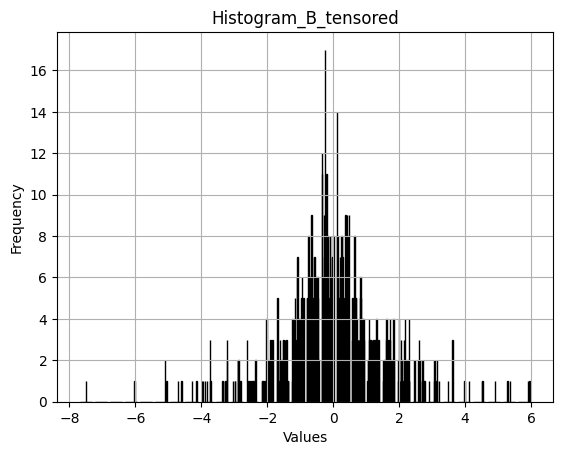

In [7]:

Norm_B = np.linalg.norm(B_tensored, ord = 'fro')
print(Norm_B**2)

print('LSR Tensor')
mean_B_ten,energy_B_ten = mean_energy(B_tensored)
print('mean',mean_B_ten,'energy:',energy_B_ten)
print('')

# Plot the histogram
plt.hist(B_tensored, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram_B_tensored')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
#samples

#for i in range (800):
#    print('Sample',i)
#    Fac_mean, Fac_energy = mean_energy(X_train[i,:,:])
#    print('mean',Fac_mean,'energy',Fac_energy)
#    print('')


#All_mean, All_energy = mean_energy(X_train )
#print('mean',All_mean,'energy:',All_energy)

<B,X>_training
mean -0.1599847594785387 energy: 526.664286342733



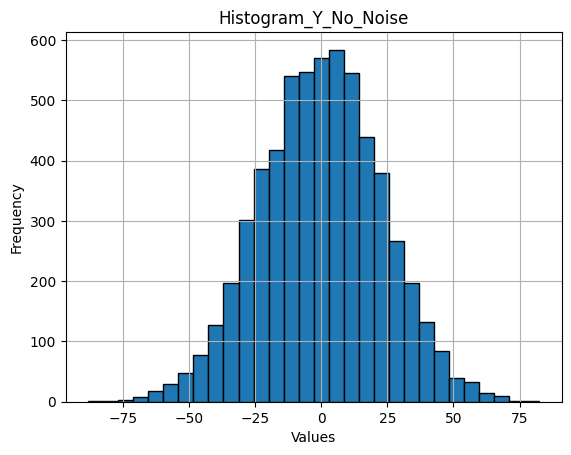

In [8]:
#No_noise

print('<B,X>_training')
mean_T_train_no,energy_T_train_no = mean_energy(Y_train_nonoise)
print('mean',mean_T_train_no,'energy:',energy_T_train_no)
print('')

# Plot the histogram
plt.hist(Y_train_nonoise, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram_Y_No_Noise')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

training
mean -0.3793416240152798 energy: 524.1218005693263



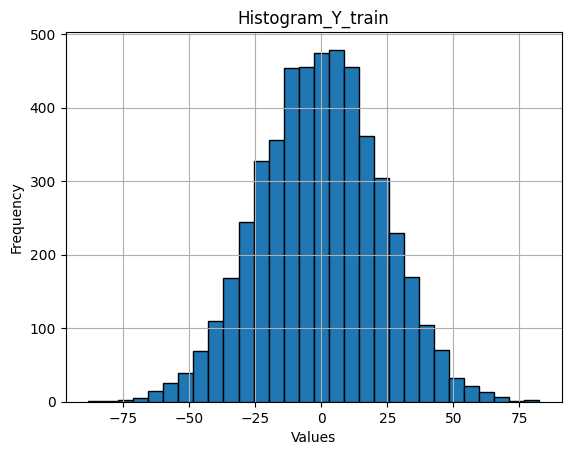

In [9]:
#training
Y_train = Y_train_all
print('training')
mean_Y,energy_Y = mean_energy(Y_train)
print('mean',mean_Y,'energy:',energy_Y)
print('')

# Plot the histogram
plt.hist(Y_train, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram_Y_train')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#still we have the error of mean shift and variance

testing
mean 0.9373463934746272 energy: 538.4167196770811



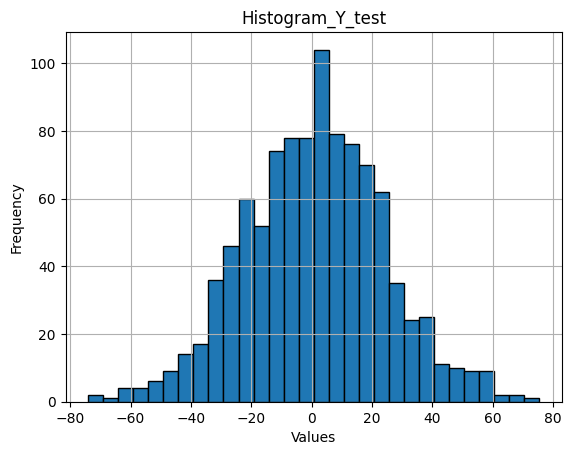

In [10]:
#testing
print('testing')
mean_Y_test,energy_Y_test = mean_energy(Y_test)
print('mean',mean_Y_test,'energy:',energy_Y_test)
print('')

# Plot the histogram
plt.hist(Y_test, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram_Y_test')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Lets run some experiments

In [11]:
#Vectorize them!
X_train = X_train_all.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape)

NameError: name 'X_train' is not defined

In [ ]:
print(np.linalg.cond(X_train))
print(np.linalg.cond((X_train.T @ X_train)+ 0.1* (np.eye(X_train.shape[1]))))


19.65768140469001
383.1394835098105
